## Import Needed Libraries

In [3]:
from pyspark.sql.functions import *
from pyspark.sql import Window
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from shapely.geometry import shape, Point
import geopandas as gpd
import json
from matplotlib import pyplot as plt

## Spark Session Creation

In [4]:
# Set the configuration for native Hadoop libraries
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.hadoop.fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

23/11/19 08:24:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
spark.conf.set("spark.hadoop.fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")


## Data Loading

In [10]:
# SparkSession Initialization
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# load the data
df = spark.read.csv("local/Sample_NYC_Data.csv", header=True, inferSchema=True)


In [11]:
#show the data
df.show()

+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|                 N|  06-01-13 0:18|   06-01-13 0:22|              1|      -74.006683|      40.731781|       -73.994499|        40.75066|


## Data Preprocessing

In [13]:
# Create an alias 'df' for DataFrame 'df'
df_1 = df.alias('df')


In [14]:
# Select specific columns from DataFrame 'df1'
df_1 = df_1.select("medallion", "hack_license", "pickup_datetime", "dropoff_datetime", "passenger_count",
                 "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude")


In [15]:
# Print the schema of DataFrame 'df_1'
df_1.printSchema()


root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [17]:
# Describe the 'passenger_count' column and convert the result to a Pandas DataFrame
passenger_count_description = df_1.select('passenger_count').describe().toPandas()


In [18]:
passenger_count_description

,summary,passenger_count
0,count,99999
1,mean,2.1630016300163
2,stddev,1.7398882948433556
3,min,0
4,max,6


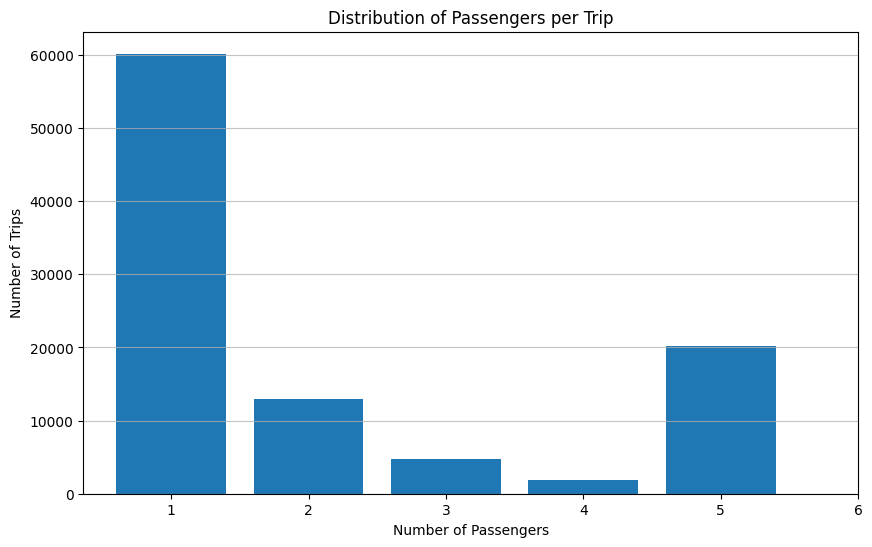

In [19]:
# Select the 'passenger_count' column
passenger_count = df_1.select("passenger_count")

# Convert the column to a Python list
passenger_count_list = passenger_count.rdd.flatMap(lambda x: x).collect()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(passenger_count_list, bins=range(1, 7), align='left', rwidth=0.8)
plt.xlabel("Number of Passengers")
plt.ylabel("Number of Trips")
plt.title("Distribution of Passengers per Trip")
plt.xticks(range(1, 7))
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show()


In [21]:
# Count the null values for each column in DataFrame 'df1'
null_counts = df_1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_1.columns])

# Display the null counts
null_counts.show()


+---------+------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|medallion|hack_license|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+---------+------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|        0|           0|              0|               0|              0|               0|              0|                0|               0|
+---------+------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+



## Geographical Distribution Analysis

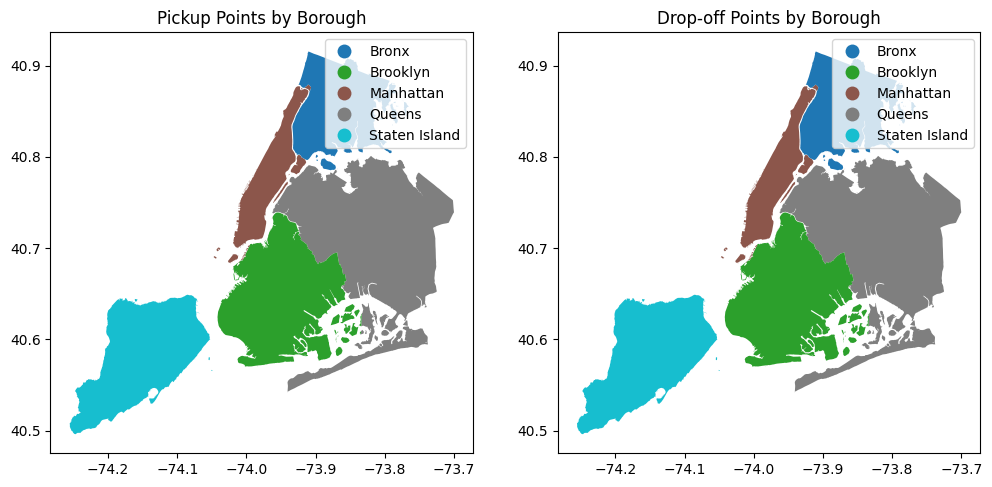

In [22]:
# Load the GeoDataFrame 'pickup_boroughs' from a local folder
pickup_boroughs = gpd.read_file("local/nyc-boroughs.geojson")

# Load the GeoDataFrame 'dropoff_boroughs' from a  local folder
dropoff_boroughs = gpd.read_file("local/nyc-boroughs.geojson")

# Create subplots for side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot pickup points by borough
pickup_boroughs.plot(column='borough', legend=True, ax=ax[0])
ax[0].set_title("Pickup Points by Borough")

# Plot drop-off points by borough
dropoff_boroughs.plot(column='borough', legend=True, ax=ax[1])
ax[1].set_title("Drop-off Points by Borough")

# Assuming you have the 'pickup_boroughs' and 'dropoff_boroughs' GeoDataFrames

plt.show()


In [24]:
# Load the GeoJSON file with boroughs using GeoPandas
gdf = gpd.read_file("local/nyc-boroughs.geojson")

# Calculate the area of each polygon and add it as a new column
gdf['area'] = gdf.geometry.area

# Sort the GeoDataFrame by area in descending order
sorted_gdf = gdf.sort_values(by='area', ascending=False)

# Define a User Defined Function (UDF) to find the borough for a given point
def get_borough(longitude, latitude):
    point = Point(float(longitude), float(latitude))
    for index, row in sorted_gdf.iterrows():
        if row['geometry'].contains(point):
            return row['borough']
    return "Unknown"

get_borough_udf = udf(get_borough, StringType())

# Create new columns for pickup and drop-off boroughs in DataFrame 'df_1'
df_1 = df_1.withColumn("pickup_borough", get_borough_udf(df_1["pickup_longitude"], df_1["pickup_latitude"]))
df_1 = df_1.withColumn("dropoff_borough", get_borough_udf(df_1["dropoff_longitude"], df_1["dropoff_latitude"]))

# Show the DataFrame with enriched data
df_1.select("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "pickup_borough", "dropoff_borough").show()


/tmp/ipykernel_18/3420579718.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area'] = gdf.geometry.area


+----------------+---------------+-----------------+----------------+--------------+---------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|pickup_borough|dropoff_borough|
+----------------+---------------+-----------------+----------------+--------------+---------------+
|      -73.978165|      40.757977|       -73.989838|       40.751171|     Manhattan|      Manhattan|
|      -74.006683|      40.731781|       -73.994499|        40.75066|     Manhattan|      Manhattan|
|      -74.004707|       40.73777|       -74.009834|       40.726002|     Manhattan|      Manhattan|
|      -73.974602|      40.759945|       -73.984734|       40.759388|     Manhattan|      Manhattan|
|       -73.97625|      40.748528|       -74.002586|       40.747868|     Manhattan|      Manhattan|
|      -73.966743|      40.764252|       -73.983322|       40.743763|     Manhattan|      Manhattan|
|      -73.995804|      40.743977|       -74.007416|       40.744343|     Manhattan|      M

In [42]:
# Convert PySpark DataFrame 'df_1' to a Pandas DataFrame
df_2=df_1.toPandas()

In [43]:
# Create a condition based on the "pickup_borough" column in Pandas DataFrame 'df_1'
condition=df_2["pickup_borough"]=="Unknown"

In [45]:
df_2[condition]

,medallion,hack_license,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_borough,dropoff_borough
73,DDB3F3E0172B1FBF0C9E39CA773CC6E3,559F071794B7213986693B57DCEDDEE5,07-01-13 22:19,07-01-13 22:39,1,0.0,0.0,0.0,0.0,Unknown,Unknown
95,0428E3DD09EA5A63D85509C7CA8C0199,A4B0B563E94A1C3ADA0B308161EDCB5A,07-01-13 16:19,07-01-13 16:24,1,0.0,0.0,0.0,0.0,Unknown,Unknown
99,DDB3F3E0172B1FBF0C9E39CA773CC6E3,559F071794B7213986693B57DCEDDEE5,07-01-13 18:42,07-01-13 18:49,1,0.0,0.0,0.0,0.0,Unknown,Unknown
100,DDB3F3E0172B1FBF0C9E39CA773CC6E3,559F071794B7213986693B57DCEDDEE5,07-01-13 20:19,07-01-13 20:23,1,0.0,0.0,0.0,0.0,Unknown,Unknown
199,6F70DA82F52A1281E4E6646AE996D25A,4103ADCF50D18CFE25AB616F368A5945,13-01-13 4:38,13-01-13 4:44,2,0.0,0.0,0.0,0.0,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
99759,1E2518C5129CB39312FBC7601C6D20ED,A736098D0C7144E35AA10EDB13F30F32,13-01-13 18:47,13-01-13 18:59,1,0.0,0.0,0.0,0.0,Unknown,Unknown
99825,6F28ECF71E4400A1BBF94EE809238BDC,7A2019218608E584ECA826E19C92851A,13-01-13 19:29,13-01-13 19:39,5,0.0,0.0,0.0,0.0,Unknown,Unknown
99886,D03EFBB5896A151FEB225F5DE544B88E,6FE0B1BAF7C02770543368A3AE37B7C9,13-01-13 19:27,13-01-13 19:34,1,0.0,0.0,0.0,0.0,Unknown,Unknown
99899,BE0396EBC842E52F724D6E724900C117,2A43B8DCB392C65C552DF21BDFE4D70F,13-01-13 17:36,13-01-13 17:36,1,0.0,0.0,0.0,0.0,Unknown,Unknown


In [49]:
# Create an alias "df1" for DataFrame "df_1"
df_3 = df_1.alias("df_1")


In [50]:
# Set the time parser policy to "LEGACY" in Spark configuration
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [53]:
# Perform transformations on DataFrame 'df_3'
df_3 = (df_3
    # Convert "pickup_datetime" and "dropoff_datetime" columns to timestamp format
    .withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"), "dd-MM-yy HH:mm"))
    .withColumn("dropoff_datetime", to_timestamp(col("dropoff_datetime"), "dd-MM-yy HH:mm"))
    # Create "hour_pickup" and "hour_dropoff" columns with "HH:mm" format
    .withColumn("hour_pickup", concat(lpad(hour("pickup_datetime"), 2, '0'),
                                         lit(":"),
                                         lpad(minute("pickup_datetime"), 2, '0')))
    .withColumn("hour_dropoff", concat(lpad(hour("dropoff_datetime"), 2, '0'),
                                          lit(":"),
                                          lpad(minute("dropoff_datetime"), 2, '0')))
)


In [54]:
# Select and display specific columns from DataFrame 'df_3'
df_3.select("pickup_datetime", "dropoff_datetime", "hour_pickup", "hour_dropoff").show()


+-------------------+-------------------+-----------+------------+
|    pickup_datetime|   dropoff_datetime|hour_pickup|hour_dropoff|
+-------------------+-------------------+-----------+------------+
|2013-01-01 15:11:00|2013-01-01 15:18:00|      15:11|       15:18|
|2013-01-06 00:18:00|2013-01-06 00:22:00|      00:18|       00:22|
|2013-01-05 18:49:00|2013-01-05 18:54:00|      18:49|       18:54|
|2013-01-07 23:54:00|2013-01-07 23:58:00|      23:54|       23:58|
|2013-01-07 23:25:00|2013-01-07 23:34:00|      23:25|       23:34|
|2013-01-07 15:27:00|2013-01-07 15:38:00|      15:27|       15:38|
|2013-01-08 11:01:00|2013-01-08 11:08:00|      11:01|       11:08|
|2013-01-07 12:39:00|2013-01-07 13:10:00|      12:39|       13:10|
|2013-01-07 18:15:00|2013-01-07 18:20:00|      18:15|       18:20|
|2013-01-07 15:33:00|2013-01-07 15:49:00|      15:33|       15:49|
|2013-01-08 13:11:00|2013-01-08 13:19:00|      13:11|       13:19|
|2013-01-08 09:50:00|2013-01-08 10:02:00|      09:50|       10

### Preprocesing : Time Interval calculation for Utilization


In [60]:
# Create an alias "df_4" for DataFrame 'df_3'
df_4 = df_3.alias('df_3')


In [61]:
# Define a window specification for partitioning and ordering
windowSpec = Window.partitionBy("medallion", "hack_license").orderBy("hour_pickup")


In [62]:
# Add a column with the previous drop-off time using the defined window specification
df_4 = df_4.withColumn("previous_dropoff_time", lag(df_4["hour_dropoff"]).over(windowSpec))


In [65]:
# Convert the "hour_pickup" and "previous_dropoff_time" columns to Unix timestamps
df_4 = df_4.withColumn("pickup_hour_unix", unix_timestamp(df_4["hour_pickup"], "HH:mm"))
df_4 = df_4.withColumn("previous_dropoff_time_unix", unix_timestamp(df_4["previous_dropoff_time"], "HH:mm"))

# Calculate the difference in hours
df_4 = df_4.withColumn("diff_hours", (df_4["pickup_hour_unix"] - df_4["previous_dropoff_time_unix"]) / 3600)

# Drop Unix timestamp columns if necessary
df_4 = df_4.drop("pickup_hour_unix", "previous_dropoff_time_unix")


In [66]:
# Remove records with NULL values in the "previous_dropoff_time" column
df_4 = df_4.filter(df_4["previous_dropoff_time"].isNotNull())


## Question 1 : Utilization: This is per taxi/driver.

In [67]:
# Create an alias "df_5" for DataFrame 'df_4'
df_5 = df_4.alias('df_4')


In [68]:
# Filter the DataFrame to keep only rows where the "diff_hours" column is less than 4
df_5 = df_5.filter(col("diff_hours") < 4)


In [69]:
# Create an alias "df5_Utilization" for DataFrame 'df_5'
df_5_Utilization = df_5.alias("df_5")


In [70]:
# Group by "dropoff_borough" and calculate the sum of "diff_hours" for utilization
df_5_Utilization = df_5_Utilization.groupBy("dropoff_borough").agg({"diff_hours": "sum"})


In [71]:
# Display the DataFrame with utilization information
df_5_Utilization.show()


+---------------+------------------+
|dropoff_borough|   sum(diff_hours)|
+---------------+------------------+
|         Queens|2056.1666666666656|
|        Unknown|  828.566666666667|
|       Brooklyn|1117.6166666666659|
|  Staten Island|0.8666666666666666|
|      Manhattan|21311.666666666628|
|          Bronx| 127.7333333333333|
+---------------+------------------+



## Question 2 : The average time it takes for a taxi to find its next fare(trip) per destination borough


In [72]:
# Create an alias "df_6" for DataFrame 'df_3'
df_6 = df_3.alias("df_3")


In [75]:
# Calculate the time to the next pickup for each row
df_6 = df_6.withColumn("next_pickup_time", lead("pickup_datetime").over(Window.partitionBy("medallion").orderBy("pickup_datetime")))

# Calculate the time difference in seconds
df_6 = df_6.withColumn("time_to_next_trip", (unix_timestamp("next_pickup_time") - unix_timestamp("dropoff_datetime")))

# Filter records where the time difference is positive (next trips)
df_6 = df_6.filter(col("time_to_next_trip") > 0)

# Group by destination borough and calculate the average time to the next trip
df_6_avg_time_next_trip = df_6.groupBy("dropoff_borough").agg(avg("time_to_next_trip").alias("avg_time_to_next_trip"))


In [76]:
df_6_avg_time_next_trip.show()

+---------------+---------------------+
|dropoff_borough|avg_time_to_next_trip|
+---------------+---------------------+
|         Queens|    6389.721592080841|
|        Unknown|    12310.46313799622|
|       Brooklyn|   6581.6850047154985|
|  Staten Island|              13935.0|
|      Manhattan|   2077.1937111374436|
|          Bronx|    4973.719008264463|
+---------------+---------------------+



## Question 3: Number of trips that started and ended within the same borough

In [81]:
# Create or replace a temporary view named "taxi_trips" for DataFrame 'df_3'
df_3.createOrReplaceTempView("taxi_trips")

In [82]:
# SQL query to calculate the number of trips within the same borough using the temporary view "taxi_trips"
trips_within_same_borough = spark.sql("""
    SELECT
        pickup_borough,
        dropoff_borough,
        COUNT(*) AS number_of_trips
    FROM taxi_trips
    WHERE pickup_borough = dropoff_borough
    GROUP BY pickup_borough, dropoff_borough
""")

In [83]:
trips_within_same_borough.show()

+--------------+---------------+---------------+
|pickup_borough|dropoff_borough|number_of_trips|
+--------------+---------------+---------------+
|     Manhattan|      Manhattan|          83561|
|      Brooklyn|       Brooklyn|           1065|
|        Queens|         Queens|           1396|
|         Bronx|          Bronx|             51|
|       Unknown|        Unknown|           1805|
| Staten Island|  Staten Island|              1|
+--------------+---------------+---------------+



## Question 4 : The number of trips that started in one borough and ended in another one


In [84]:
# SQL query to calculate the number of trips across different boroughs using the temporary view "taxi_trips"
trips_across_boroughs = spark.sql("""
    SELECT
        pickup_borough,
        dropoff_borough,
        COUNT(*) AS number_of_trips
    FROM taxi_trips
    WHERE pickup_borough <> dropoff_borough
    GROUP BY pickup_borough, dropoff_borough
""")


In [85]:
trips_across_boroughs.show()

+--------------+---------------+---------------+
|pickup_borough|dropoff_borough|number_of_trips|
+--------------+---------------+---------------+
|      Brooklyn|      Manhattan|            774|
|        Queens|          Bronx|            100|
|         Bronx|         Queens|              2|
| Staten Island|         Queens|              1|
|       Unknown|      Manhattan|            106|
|      Brooklyn|         Queens|            115|
|        Queens|  Staten Island|              2|
|     Manhattan|  Staten Island|              9|
|        Queens|        Unknown|            119|
|     Manhattan|       Brooklyn|           1923|
|       Unknown|         Queens|             18|
|       Unknown|  Staten Island|              1|
|     Manhattan|         Queens|           3943|
|      Brooklyn|        Unknown|             11|
|     Manhattan|          Bronx|            244|
|        Queens|      Manhattan|           3698|
|         Bronx|      Manhattan|             25|
|       Unknown|    